In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from sklearn.datasets import load_digits

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [12]:
digits = load_digits()
print(digits['data'])
print(digits.target)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


In [16]:
def visualize(z_pred, method):
    for i in range(10):
        idx = digits.target == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

In [21]:
visualize(core.ikd_blockwise(digits['data'], d_latent=2, max_n_cliques=2), 'IKD')

TypeError: '<=' not supported between instances of 'NoneType' and 'float'

Only one clique, identical to full eigen-decomposition


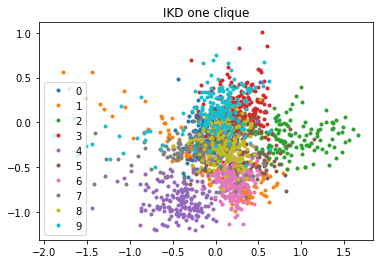

In [19]:
visualize(core.ikd_blockwise(digits['data'], d_latent=2, clique_th=0, max_n_cliques=2), 'IKD one clique')